### Analyses of output files from the pipeline optimus v6.0.0+
#### Aim of this part of analysis is to realize the Feature selection

NB: This part of analysis was performed on google VM if you want to use scry

#### Load necessary libraries and useful functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext rpy2.ipython

In [3]:
import warnings
warnings.filterwarnings("ignore") 

In [5]:
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import anndata2ri

ro.pandas2ri.activate()
anndata2ri.activate()

In [6]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

#### Data Loading

In [8]:
input_h5ad = "../scAtlas/tmp/10k_pbmc_v3_out_normalize_layer.h5ad"
adata = sc.read_h5ad(input_h5ad)

In [9]:
display(adata)

AnnData object with n_obs × n_vars = 10214 × 58347
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'scDblFinder_score', 'scDblFinder_class', 'S_score', 'G2M_score', 'phase'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_tes

###### check barcode and gene names

In [10]:
adata.raw = adata.copy()

#### Feature selection

scanpy

In [ ]:
"""
# alix's code
genes_info = sc.pp.highly_variable_genes(adata, inplace=False)
adata.var["highly_variable"] = genes_info[
    "highly_variable"
].to_numpy()  # The to_numpy is here to allow assignation without an index
"""

In [11]:
# identify the highly variable genes
sc.pp.highly_variable_genes(adata, layer="log1p_norm", min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)

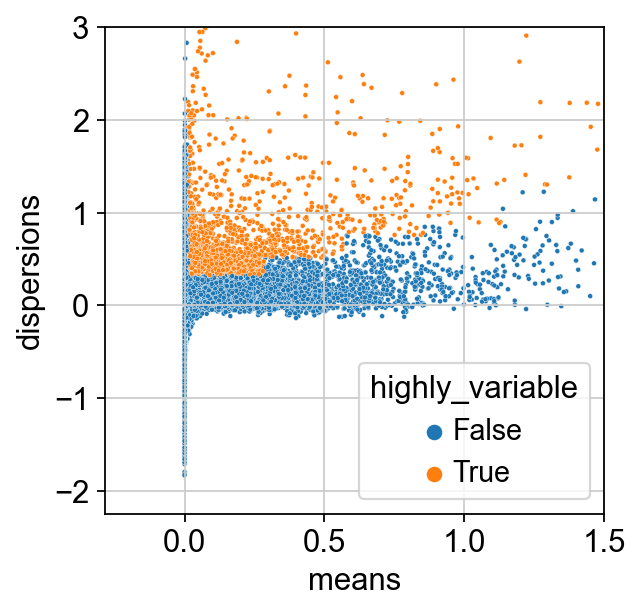

In [12]:
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_variable", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

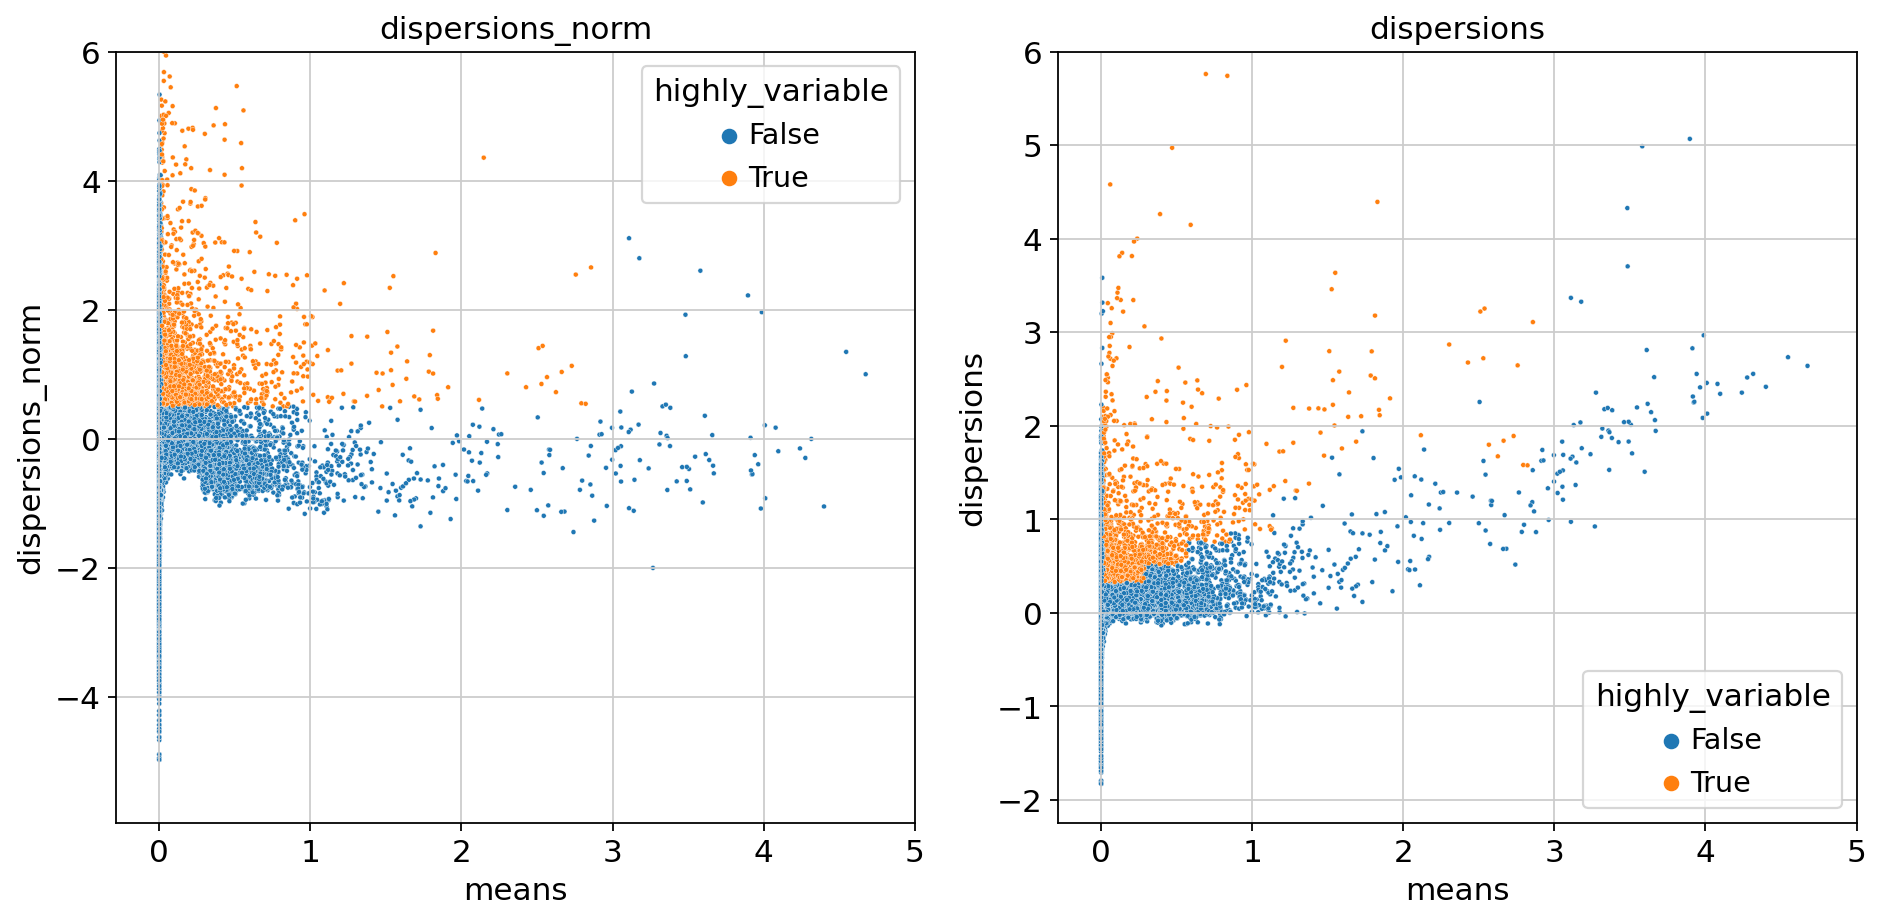

In [34]:
# visualization: using sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatterplot on the left
ax1 = sns.scatterplot(data=adata.var, x="means", y="dispersions_norm", hue="highly_variable", s=5, ax=ax1)
ax1.set_xlim(None, 5)
ax1.set_ylim(None, 6)
ax1.set_title("dispersions_norm")

# Plot the second scatterplot on the right
ax2 = sns.scatterplot(data=adata.var, x="means", y="dispersions", hue="highly_variable", s=5, ax=ax2)
ax2.set_xlim(None, 5)
ax2.set_ylim(None, 6)
ax2.set_title("dispersions")

plt.tight_layout()
plt.show()

In [19]:
sc_hvg_lst = adata.var.index[adata.var["highly_variable"]].tolist()
print(len(sc_hvg_lst)) #sc_adata.var["highly_variable"].sum()

2707


#### Write output to h5ad

In [20]:
PATH_TO_OUTPUT = "../scAtlas/tmp/10k_pbmc_v3_out_feature_selection.h5ad"
adata.write_h5ad(PATH_TO_OUTPUT)

#### Optional analysis

scry

In [9]:
%%R
library(scry)

In [49]:
# save the AnnData object in our R environment
ro.globalenv["adata"] = adata

In [50]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [51]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [52]:
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

In [ ]:
# Fetch the highly deviant genes
highly_deviant_values = adata.var.loc[adata.var["highly_deviant"], "highly_deviant"]

In [43]:
%%R
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS/LAPACK: /home/xiliu/.conda/envs/optimus/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Matrix_1.6-1.1              SingleCellExperiment_1.22.0
 [3] SummarizedExperiment_1.30.2 Biobase_2.60.0             
 [5] GenomicRanges_1.52.0        GenomeInfoDb_1.36.1        
 [7] IRanges_2.34.1              MatrixGenerics_1.12.2      
 [9] matrixS